Attention



In [6]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.resnet50 import preprocess_input

tf.executing_eagerly()

True

In [7]:
resnet_50 = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


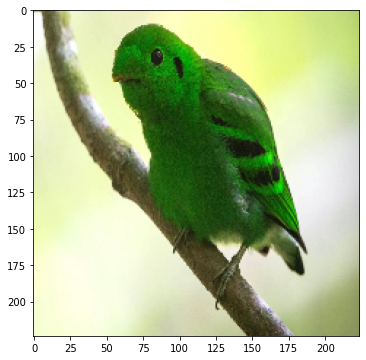

In [8]:
img = cv2.imread("bird_2.jpg")[:,:,::-1]
img = cv2.resize(img, (224, 224))
ax = plt.imshow(img)

In [9]:
def preprocess(img):
  # use the pre processing function of ResNet50 
  img = preprocess_input(img)
  
  #expand the dimension
  return np.expand_dims(img, 0)

In [10]:
input_image = preprocess(img)

## Activation Maps
Given the pretrained model we want to extract the activation maps at a certain layer. We index the layers using natural numbers. The activation maps at a given index is a function of the form 

$$f: \mathbb{R}^{H \times W \times 3} \to \mathbb{R}^{H' \times W' \times C}$$

In simple terms, given an input image of three channels the output is a 3-d tensor representing the activation at the given layer.

In [11]:
def get_activations_at(input_image, i):
  #index the layer 
  out_layer = resnet_50.layers[i]
  
  #change the output of the model 
  model = tf.keras.models.Model(inputs = resnet_50.inputs, outputs = out_layer.output)
  
  #return the activations
  return model.predict(input_image)

## Attention Maps
After getting the activations in the shape $(H', W', C)$ we want to represent what parts of the image is the activation paying attention to the most. To do that we need to convert the shape of the activations to the form $(H', W')$ or mathematically 

$$g: \mathbb{R}^{H' \times W' \times C} \to \mathbb{R}^{H' \times W'} $$

We call $g$ a spatial attention map function  [ref](https://arxiv.org/pdf/1612.03928.pdf). There are many functions that we could use as described by the paper. In this demo we will use the sum of the absolute value of the activations across the channel. Formally, given an activation $A$ we define $A_i = A[:,:,i]$ which represents an index across the channel dimension. Then we can evaluate the attention map as 

$$g(A) = \sum_{i=1}^C |A_i|$$

In [12]:
def postprocess_activations(activations):

  #using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(activations)
  output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image 
  output = cv2.resize(output, (224, 224))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

## Generate Heatmaps 

For visuals we use the functions `applyColorMap` and `addWeighted`

In [13]:
def apply_heatmap(weights, img):
  #generate heat maps 
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
  return heatmap

In [14]:
def plot_heatmaps(rng):
  level_maps = None
  
  #given a range of indices generate the heat maps 
  for i in rng:
    activations = get_activations_at(input_image, i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights, img)
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = np.concatenate([level_maps, heatmap], axis = 1)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  ax = plt.imshow(level_maps)

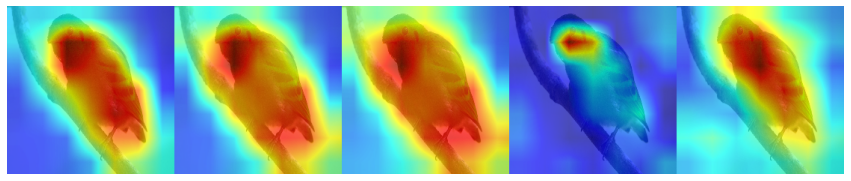

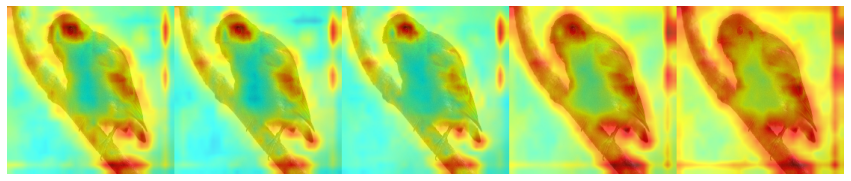

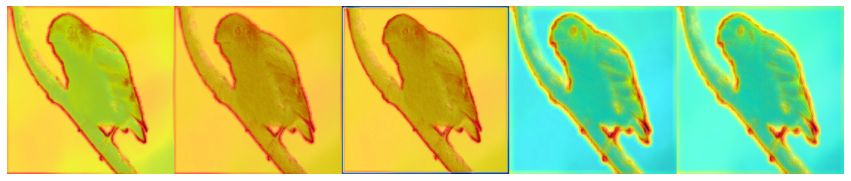

In [15]:
plot_heatmaps(range(164, 169))
plot_heatmaps(range(76, 81))
plot_heatmaps(range(3, 8))